# Exam Part A

On this file we setup and modify a simple VMC simulation of the Helium atom! We divide this notebook in the following sections:
- Imports: Import Python modules
- Hydrogen Atom: Specify the wave function we are using
- Metropolis Sampling: Sampling the desired wave function using the Metropolis Algorithm
- Sweep Variational Parameter: Sweep our variational parameter and determine the energy minimum
- Optimize with Virial Theorem (Question A1): Use the virial theorem to find the best variational parameter


# Imports

In [70]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

# Hydrogen Atom

We will start by studying the Hydrogen Atom:

$$
\begin{align*}

H &= -\frac12(\nabla^2_1 + \nabla_2^2) - \frac2{r_1} - \frac2{r_2} + |\textbf r_1 - \textbf r_2|
\\\\


\psi(\textbf r_1, \textbf r_2) &= e^{-\beta r_1}e^{\beta r_2}

\end{align*}
$$

# Metropolis Sampling

In [71]:
def rvec(pos: np.ndarray) -> float:
    return np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)


def rxyz(x: float, y: float, z:float) -> float:
    return np.sqrt(x**2 + y**2 + z**2)


def samplePos(M: int, beta: float, delta: float = 0.5) -> tuple[np.ndarray, np.ndarray]:
    """
        Samples M positions taking as the desired distribution psi, assuming psi is real!
    """

    # List of samples
    samples1 = np.zeros((M), dtype=float)
    samples2 = np.zeros((M), dtype=float)
    samplesd = np.zeros((M), dtype=float)

    # Starting position
    x1, y1, z1 = 10, 0.1, 0.01
    x2, y2, z2 = 0.1, 0.2, 0.3
    r1 = rxyz(x1, y1, z1)
    r2 = rxyz(x2, y2, z2)
    dr = rxyz(x1-x2, y1-y2, z1-z2)

    samples1[0] = r1
    samples2[0] = r2
    samplesd[0] = dr

    logpsi = -beta * (r1 + r2)

    # Metropolis Loop
    succ = 0
    for attempt in range(M-1):
        # Moves for electron 1
        xp1 = x1 + delta*(np.random.random() - 0.5)
        yp1 = y1 + delta*(np.random.random() - 0.5)
        zp1 = z1 + delta*(np.random.random() - 0.5)
        
        # Moves for electron 2
        xp2 = x2 + delta*(np.random.random() - 0.5)
        yp2 = y2 + delta*(np.random.random() - 0.5)
        zp2 = z2 + delta*(np.random.random() - 0.5)

        rp1 = rxyz(xp1, yp1, zp1)
        rp2 = rxyz(xp2, yp2, zp2)
        logpsip = -beta * (rp1 + rp2)

        accept = min(1, np.exp(2 * (logpsip - logpsi)))

        # Metropolis question
        if accept > np.random.random():
            succ += 1

            x1, y1, z1 = xp1, yp1, zp1
            r1 = rp1
            
            x2, y2, z2 = xp2, yp2, zp2
            r2 = rp2

            logpsi = logpsip
            dr = rxyz(xp1-xp2, yp1-yp2, zp1-zp2)
        
        # Save state
        samples1[attempt+1] = r1
        samples2[attempt+1] = r2
        samplesd[attempt+1] = dr
    
    print(f"Acceptance: {succ / attempt}")
    return (samples1, samples2, samplesd)

In [72]:
# Calculate statistics
def sampleNeff(data: np.ndarray, k1: int = 0, icutoff: int = 200) -> int:
    # Equilibriation
    data = data[k1:]

    # Raw data
    Neq = len(data)

    # Calculate Stats
    ave = np.mean(data)
    var = np.var(data, mean=ave, ddof=1)

    # Calculate autocorrelations and cutoff
    autocorr = np.array([np.mean((data[: Neq-i]-ave) * (data[i:]-ave)) for i in range(1, icutoff+1)]) / (var)

    # Calculate autocorrelation time (sum until we find some negative number)
    timecorr = 1 + 2 * np.sum(autocorr * (np.arange(len(autocorr)) < np.argmax(autocorr < 0)))

    Neff = Neq / timecorr

    return ave, var, timecorr, Neff

# Optimize with Virial Theorem (Question A1)

From the virial theorem we know that:
$$
\begin{align*}
2\lang T \rang + \lang V\rang = 0
\end{align*}
$$

Therefore in our simulation we want to minimize:
$$
\begin{align*}
f_\text{target} = |2\lang T \rang + \lang V\rang|
\end{align*}
$$

---

Now, we can see that for the interacting problem the optimal $\beta$ is around $1.7$ which is lower then $2.0$. This is expected because:
1. Higher $\beta$ means that the electrons are more localized close to the nucleus (the wave function for electron $i$ decays faster as $r_i$ increases).
2. The electron-electron interactions are repulsive, which means that when we consider this interaction, we predict that the electrons will be further away from each other, and as such further away from the nucleus. As we have seen, this means lower $\beta$.

Beta = 1.000
Acceptance: 0.6767353470694139
Energy = -2.4068464487268444
Energy Kin = 1.031944211929257
Energy Pot = -3.438790660656102
Target Function f = 1.3749022367975874
Variance on f = 0.351121209953495
Correlation Time: 27.743129598826624
Neff: 360.4496012022718
Standard Deviation on Mean f= 0.031210897508140684

Beta = 1.100
Acceptance: 0.657631526305261
Energy = -2.4512464746939107
Energy Kin = 1.1252365691813524
Energy Pot = -3.576483043875263
Target Function f = 1.3260099055125583
Variance on f = 0.46818069065403056
Correlation Time: 26.443738808922014
Neff: 378.1613512468229
Standard Deviation on Mean f= 0.035185860653159956

Beta = 1.200
Acceptance: 0.6333266653330666
Energy = -2.626941613073146
Energy Kin = 1.4438614259737674
Energy Pot = -4.070803039046914
Target Function f = 1.1830801870993786
Variance on f = 1.0352773925785472
Correlation Time: 25.39578192299203
Neff: 393.76617858521286
Standard Deviation on Mean f= 0.0512754121306973

Beta = 1.300
Acceptance: 0.597119

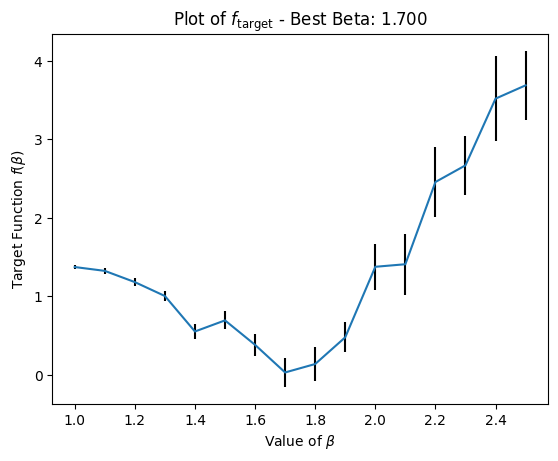

In [110]:
# Parameters
sampleM = 10000
discard = 0
delta = 1.0

# Sweep Variational Parameter
betaMin = 1
betaMax = 2.5

fbeta = []
fstd = []
fvar = []
bbRange = np.linspace(betaMin, betaMax, 16)
for betaStart in bbRange:
    # Run VMC for this beta
    print(f"Beta = {betaStart:.3f}")
    Rs1, Rs2, Rsd = samplePos(sampleM, betaStart, delta)
    Rs1, Rs2, Rsd = Rs1[discard:], Rs2[discard:], Rsd[discard:]

    # Calculate energies
    Ekin = -betaStart**2 + betaStart * (1/Rs1 + 1/Rs2)
    Epot = - (2/Rs1 + 2/Rs2) + 1/Rsd
    El = Ekin + Epot

    # Calculate target function
    ftarget = 2 * Ekin + Epot

    # Get the statistics
    ave, var, timecorr, Neff = sampleNeff(ftarget)
    ave = abs(ave)

    # Save the desired values
    fvar += [var]
    fstd += [np.sqrt(var) / np.sqrt(Neff)]
    fbeta += [ave]

    # Print results
    print(f"Energy = {np.average(El)}")
    print(f"Energy Kin = {np.average(Ekin)}")
    print(f"Energy Pot = {np.average(Epot)}")
    print(f"Target Function f = {fbeta[-1]}")
    print(f"Variance on f = {fvar[-1]}")
    print(f"Correlation Time: {timecorr}")
    print(f"Neff: {Neff}")
    print(f"Standard Deviation on Mean f= {fstd[-1]}")
    print("")

# Plot results
betaBest = bbRange[fbeta.index(np.min(fbeta))]
print(f"Best beta: {betaBest}")
plt.errorbar(bbRange, fbeta, yerr=fstd, ecolor="black")
plt.xlabel("Value of $\\beta$")
plt.ylabel("Target Function $f(\\beta)$")
plt.title("Plot of $f_\\text{target}$ - " + f"Best Beta: {betaBest:.3f}")

plt.savefig(f"./Plots/he-out-virial.png")

# Studying Variance (Question A2)

We create some files:
- A file in ./Outputs/he-out-var.txt which has two columns: The first is the beta and the second is the variance on the energy
- Three files in ./Outputs/he-out-var-statfor-beta=x.xx.txt: Results of statfor for the simulation with beta = x.xx

We can see that our variance is the same as the one calculated by statfor using the command `tail -13500 ./Outputs/he-out-beta=x.xx.txt | ./statfor.x > ./Outputs/he-out-var-statfor-beta=x.xx.txt` where we replace `x.xx` with the correct beta (e.g. `1.00`)

---

Now, we can see that because the electron-electron cusp condition is not fullfiled, we have that:
1. The local energy diverges as the distance $r$ between electrons decreases.
2. The variance of the local energy diverges, which can be observed in our plot as the increasing error as $\beta$ increases.
3. The variational energy does not diverge because VMC is still able to calculate its expected value given our trial wave function.

Beta = 1.000
Acceptance: 0.6954260568075743
Energy = -2.3070326083964345
Variance on Energy = 1.9608052373126867
Correlation Time: 10.274482172609243
Neff: 1313.9348312842149
Standard Deviation on Mean Energy = 0.03863049884600205

Beta = 1.100
Acceptance: 0.6650886784904654
Energy = -2.4971632134580437
Variance on Energy = 1.3580124145673742
Correlation Time: 13.723351092689029
Neff: 983.7247410504555
Standard Deviation on Mean Energy = 0.03715481241282853

Beta = 1.200
Acceptance: 0.6216828910521403
Energy = -2.6411435656894744
Variance on Energy = 1.5825515066249254
Correlation Time: 12.362155339113329
Neff: 1092.0425791194016
Standard Deviation on Mean Energy = 0.03806791937717438

Beta = 1.300
Acceptance: 0.605414055207361
Energy = -2.6901240996595415
Variance on Energy = 1.0834164768008165
Correlation Time: 11.463184103602197
Neff: 1177.6832578094732
Standard Deviation on Mean Energy = 0.030330772217207643

Beta = 1.400
Acceptance: 0.5670756100813442
Energy = -2.7806147020561216


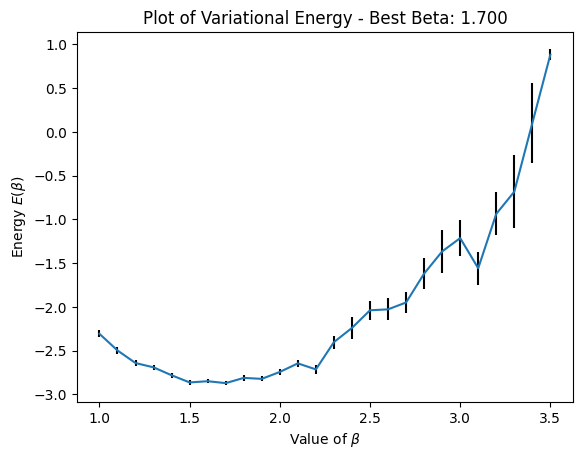

In [115]:
# Parameters
sampleM = 15000
discard = 1500
delta = 1.0

# Create file where to save the variances
with open(f"./Outputs/he-out-var.txt", "w") as file:
    file.write("")

# Sweep Variational Parameter
betaMin = 1
betaMax = 3.5

Ebeta = []
Estd = []
Evar = []
bbRange = np.linspace(betaMin, betaMax, 26)
for betaStart in bbRange:
    # Run VMC for this beta
    print(f"Beta = {betaStart:.3f}")
    Rs1, Rs2, Rsd = samplePos(sampleM, betaStart, delta)
    Rs1, Rs2, Rsd = Rs1[discard:], Rs2[discard:], Rsd[discard:]

    # Calculate energies
    Ekin = -betaStart**2 + betaStart * (1/Rs1 + 1/Rs2)
    Epot = - (2/Rs1 + 2/Rs2) + 1/Rsd
    El = Ekin + Epot

    # Get the statistics
    ave, var, timecorr, Neff = sampleNeff(El)

    # Save the data (we can analyse it using statfor later!)
    with open(f"./Outputs/he-out-beta={betaStart:.2f}.txt", "w") as file:
        for i in range(len(El)):
            file.write(f"{El[i]}\t{Ekin[i]}\t{Epot[i]}\n")
        
    
    with open(f"./Outputs/he-out-var.txt", "a") as file:
        file.write(f"{betaStart:.3f}\t{var}\n")

    # Save the desired values
    Evar += [var]
    Estd += [np.sqrt(var) / np.sqrt(Neff)]
    Ebeta += [ave]

    # Print results
    print(f"Energy = {Ebeta[-1]}")
    print(f"Variance on Energy = {Evar[-1]}")
    print(f"Correlation Time: {timecorr}")
    print(f"Neff: {Neff}")
    print(f"Standard Deviation on Mean Energy = {Estd[-1]}")
    print("")

# Plot results
betaBest = bbRange[Ebeta.index(np.min(Ebeta))]
print(f"Best beta: {betaBest}")
plt.errorbar(bbRange, Ebeta, yerr=Estd, ecolor="black")
plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Plot of Variational Energy - " + f"Best Beta: {betaBest:.3f}")

plt.savefig(f"./Plots/he-out-var.png")

# Optimize with Reweighting (Question A3)

We start with a value of $\beta$ called `betaMid` and:
1. Sample from the wave function with beta qual to `betaMid`.
2. Use the reweighting method to calculate the variational enegy for $\beta$ close to our `betaMid` using the sample from 1.
3. Find the lowest energy and set `betaMid` equal to its corresponding $\beta$ and then go back to step 1.

We repeat this process the desired amount of times (e.g. 5) with a decreasing range of new $\beta$ in step 2.

BetaMid = 2.000
Acceptance: 0.43559631978970226

BetaMid = 1.733
Acceptance: 0.49194239670838336

BetaMid = 1.693
Acceptance: 0.504085947768444

BetaMid = 1.717
Acceptance: 0.49988570775472885

Final beta: 1.7173333333333334
Minimum energy: -2.8663387166880274


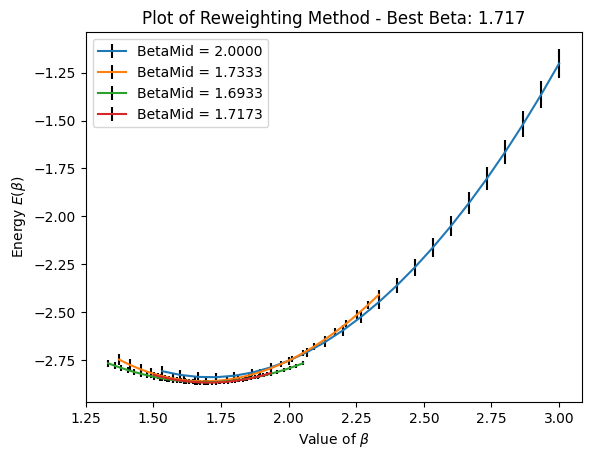

In [117]:
# Sampling Parameters
sampleM = 35000
discard = 2000

delta = 1.0

# Target Function is energy + stdW * std
stdW = 2

# Starting Variational Parameters
betaStart = 2

betaRange = 1
betaSamples = 31
betaMult = 0.6

betaSteps = 4

betaMid = betaStart
for _ in range(betaSteps):
    betaMin = betaMid - betaRange
    betaMax = betaMid + betaRange

    Ebeta = []
    Estd = []
    bb = []
    bbRange = np.linspace(betaMin, betaMax, betaSamples)
    
    print(f"BetaMid = {betaMid:.3f}")
    Rs1, Rs2, Rsd = samplePos(sampleM, betaMid, delta)
    Rs1, Rs2, Rsd = Rs1[discard:], Rs2[discard:], Rsd[discard:]
    El = -betaMid**2 + betaMid * (1/Rs1 + 1/Rs2) - (2/Rs1 + 2/Rs2) + 1/Rsd
    ave, var, timecorr, Neff = sampleNeff(El)
    for beta in bbRange:
        # Calculate weights
        ww = np.exp(-2 * (beta - betaMid) * (Rs1 + Rs2))

        # Effective number of points
        m = ((np.sum(ww))**2 / np.sum(ww**2)) / len(El)
        if m < 0.5:
            continue

        bb += [beta]

        El = -beta**2 + beta * (1/Rs1 + 1/Rs2) - (2/Rs1 + 2/Rs2) + 1/Rsd
        Estd += [np.std(El) / np.sqrt(Neff)]
        Ebeta += [(np.sum(El * ww)) / (np.sum(ww))]
    
    # Plot results
    plt.errorbar(bb, Ebeta, yerr=Estd, ecolor="black", label=f"BetaMid = {betaMid:.4f}")
    
    # Target function
    target = [Ebeta[i] + stdW * Estd[i] for i in range(len(bb))]

    betaMini = bb[target.index(min(target))]
    betaMid = betaMini
    betaRange *= betaMult
    print("")


print(f"Final beta: {betaMini}")
print(f"Minimum energy: {min(Ebeta)}")

plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Plot of Reweighting Method - " + f"Best Beta: {betaMini:.3f}")
plt.legend()

plt.savefig(f"./Plots/he-out-weighting.png")